In [82]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import defaultdict

# Auxiliares

In [2]:
# K = cantidad de clases a crear, n = cantidad de puntos por clase, d = dispersción de los datos, medias = vector de medias de las clases crear.
def generador_puntos_clases(K, n, d, medias):
	unitaria = np.eye(K)
	cov = np.array([[d**2, 0], [0, d**2]])

	X, T = np.array([]), np.array([])
	for c in range(K):
		media = np.array(medias[c])
		X = np.append(X, np.random.multivariate_normal(media, cov, size=n))
		T = np.append(T, np.ones((n, K)) * unitaria[c])

	return X.reshape((K*n, 2)), T.reshape((K*n), K)
 
def generador_dos_clases(n,d,medias):
  X,T = generador_puntos_clases(2,n,d,medias)
  X_new = []
  T_new = []
  for t in T:
    if np.argmax(t) == 0:
      T_new.append(-1)
    else:
      T_new.append(1)
    
  for x in X:
    X_new.append([1,x[0],x[1]])

  return X_new,T_new

# Defino la función separador(x,w,n) que es el polinomio evaluado en x, con los w como hiperparámetros (w perteneciente a R3) para poder graficar la recta que separa (caso donde no hay kernel).
def separador(x, W, n):
  resultado = (x*W[1] + W[0] - n)/(-1*W[2])
  return resultado

# Algoritmo Pegasus (Sin Kernel)

**Aclaraciones**: 
 
- El algoritmo así como está en el paper/clase solo devuelve el vector $w$, pero no devuelve $w_0$ (o bias). Para conseguirlo en el paper se proponen tres alternativas, la que vamos a usar es la primera: 

  "The first approach is rather well known and its roots go back to early work
on pattern recognition. This approach simply amounts to adding one more
feature to each instance x thus increasing the dimension to n + 1. The artificially added feature always takes the same value. We assume without loss of generality that the value of the constant feature is 1. Once the constant feature is added the rest of the algorithm remains intact, thus the bias term is not explicitly introduced."

  Para conseguir esto vamos a cambiar los puntos generados y agregarle a todos un 1 adelante. Esto se hace dentro del generador mismo.

- $C = \frac{1}{\lambda n}$ siendo $n$ el largo de $X$.

- El algoritmo cuenta con la posibilidad de cortar el ciclo de iteraciones cuando el error converge. Esto fue sugerido por el profesor, pero no lo recomendamos ya que hace que se pierdan las caracteristicas de SVM.

**Concluciones:**

- La penalización importa y mucho. Una mala selección de lambda puede hacer que el nivel de generalización del modelo sea muy bajo. 

  En general, elegir un lambda muy chico genera overfitting (significa elegir una $C$ más grande o lo que es lo mismo penalizar mucho los valores mal clasificados y los que caen dentro del $(0, 1)$ o $(-1, 0)$. La manera en la que queda expresada esta penalización por el modelo es "pegar" el hiperplano separador a los vectores de soporte y también achicar los margenes.

- Hay una componente aleatoria, que hace que a veces bajos las mismas condiciones, el modelo funcione muy bien y en otras no tanto.

In [3]:
def error(w, X, T):
  total = 0
  for x, t in zip(np.dot(w, np.transpose(X)), T):
    s = t * x
    if s < 0:
      total += abs(s)
  #print(total)
  return total

def pegasos(X, T, lam=1, cantIter = 60000, with_error=False, epsilon=0.0000001):            # C = 1/lambda*n siendo n len(X)
  w = np.zeros(len(X[0]))
  errors = []
  for iter in range(cantIter):
    i = random.randint(0,len(X)-1)
    x, t = X[i], T[i] 
    step = 1./(lam*(iter+1))                                                                # is the step length in gradient descent.
    w = (1 - step * lam) * np.array(w)
    if (t * np.dot(w,np.transpose(x))) < 1:
      w += step * t * np.array(x)

    errors.append(error(w, X, T))
    if with_error and len(errors) > 3 and (all(e < epsilon for e in errors[-3:]) or abs(errors[-1] - errors[-2]) < epsilon):
      break

  return w, errors
  #return w

## Linealmente separable

In [7]:
random.seed(1000)

X_linealmente_separable,T_linealmente_separable = generador_dos_clases(50, 1, [[10,10],[15,15]])

[-15.05555556   0.57889098   0.61669908]
Mal clasificados: 0


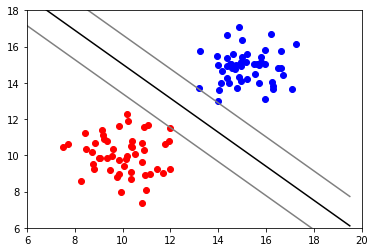

In [27]:
## Caso linealmente separable ##
random.seed(1003)

mal_clasificados = 0
linealmente_separable, errores = pegasos(X_linealmente_separable,T_linealmente_separable,lam=0.0009, with_error=False)

for x,t in zip(X_linealmente_separable,T_linealmente_separable):
  if np.dot(linealmente_separable,np.transpose(x)) >= 0:
    plt.scatter(x[1],x[2],c="blue")
    if t < 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="yellow")
  elif np.dot(linealmente_separable,np.transpose(x)) < 0:
    plt.scatter(x[1],x[2],c="red")
    if t > 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="deepskyblue")

x = np.arange(0.0, 20.0, 0.5)
plt.xlim([6,20])
plt.ylim([6,18])
plt.plot(x, separador(x,linealmente_separable,0),c="black")
plt.plot(x, separador(x,linealmente_separable,1),c="grey")
plt.plot(x, separador(x,linealmente_separable,-1),c="grey")

print(linealmente_separable)
print("Mal clasificados:",mal_clasificados)

[-30.66666667   2.30758766   0.11685087]
Mal clasificados: 0


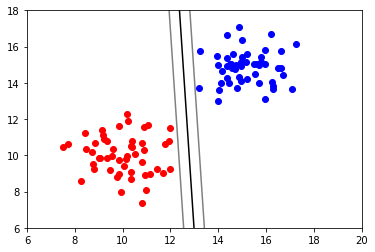

In [29]:
## Caso linealmente separable, penalizacion alta ##
random.seed(1002)

mal_clasificados = 0
linealmente_separable, errores = pegasos(X_linealmente_separable,T_linealmente_separable,lam=0.0001, with_error=False)

for x,t in zip(X_linealmente_separable,T_linealmente_separable):
  if np.dot(linealmente_separable,np.transpose(x)) >= 0:
    plt.scatter(x[1],x[2],c="blue")
    if t < 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="yellow")
  elif np.dot(linealmente_separable,np.transpose(x)) < 0:
    plt.scatter(x[1],x[2],c="red")
    if t > 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="deepskyblue")

x = np.arange(0.0, 20.0, 0.5)
plt.xlim([6,20])
plt.ylim([6,18])
plt.plot(x, separador(x,linealmente_separable,0),c="black")
plt.plot(x, separador(x,linealmente_separable,1),c="grey")
plt.plot(x, separador(x,linealmente_separable,-1),c="grey")

print(linealmente_separable)
print("Mal clasificados:",mal_clasificados)

[-6.08148148  0.28729424  0.20921444]
Mal clasificados: 0


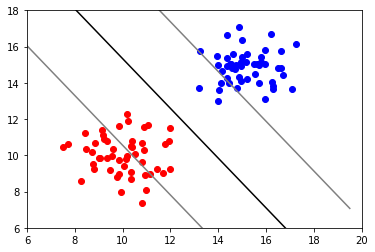

In [31]:
## Caso linealmente separable, penalizacion baja ##
random.seed(1001)

mal_clasificados = 0
linealmente_separable, errores = pegasos(X_linealmente_separable,T_linealmente_separable,lam=0.009)

for x,t in zip(X_linealmente_separable,T_linealmente_separable):
  if np.dot(linealmente_separable,np.transpose(x)) >= 0:
    plt.scatter(x[1],x[2],c="blue")
    if t < 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="yellow")
  elif np.dot(linealmente_separable,np.transpose(x)) < 0:
    plt.scatter(x[1],x[2],c="red")
    if t > 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="deepskyblue")

x = np.arange(0.0, 20.0, 0.5)
plt.xlim([6,20])
plt.ylim([6,18])
plt.plot(x, separador(x,linealmente_separable,0),c="black")
plt.plot(x, separador(x,linealmente_separable,1),c="grey")
plt.plot(x, separador(x,linealmente_separable,-1),c="grey")

print(linealmente_separable)
print("Mal clasificados:",mal_clasificados)

## Linealmente no separables (Solapadas)

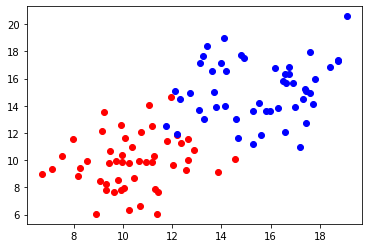

In [65]:
random.seed(1000)
X_no_linealmente_separable,T_no_linealmente_separable = generador_dos_clases(50, 2, [[10,10],[15,15]])

for x,t in zip(X_no_linealmente_separable,T_no_linealmente_separable):
  if t == 1:
    plt.scatter(x[1],x[2],c ="blue")
  if t == -1:
    plt.scatter(x[1],x[2],c ="red")

[-40.2          1.00406263   2.17992356]
Mal clasificados: 3


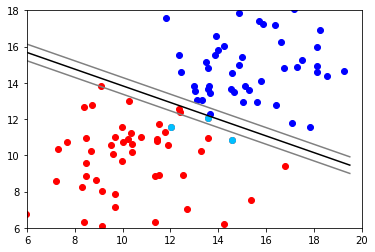

In [23]:
## Caso linealmente no separable ##
random.seed(1003)

mal_clasificados = 0
no_linealmente_separable, errores = pegasos(X_no_linealmente_separable,T_no_linealmente_separable,lam=0.0005,with_error=False)

for x,t in zip(X_no_linealmente_separable,T_no_linealmente_separable):
  if np.dot(no_linealmente_separable,np.transpose(x)) >= 0:
    plt.scatter(x[1],x[2],c="blue")
    if t < 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="yellow")
  elif np.dot(no_linealmente_separable,np.transpose(x)) < 0:
    plt.scatter(x[1],x[2],c="red")
    if t > 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="deepskyblue")

x = np.arange(0.0, 20.0, 0.5)
plt.xlim([6,20])
plt.ylim([6,18])
plt.plot(x, separador(x,no_linealmente_separable,0),c="black")
plt.plot(x, separador(x,no_linealmente_separable,1),c="grey")
plt.plot(x, separador(x,no_linealmente_separable,-1),c="grey")

print(no_linealmente_separable)
print("Mal clasificados:",mal_clasificados)

[-173.83333333    5.65357825    8.60033283]
Mal clasificados: 4


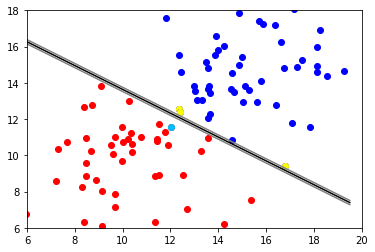

In [25]:
## Caso linealmente no separable penalizacion alta ##
random.seed(1000)

mal_clasificados = 0
no_linealmente_separable, errores = pegasos(X_no_linealmente_separable,T_no_linealmente_separable,lam=0.0001)

for x,t in zip(X_no_linealmente_separable,T_no_linealmente_separable):
  if np.dot(no_linealmente_separable,np.transpose(x)) >= 0:
    plt.scatter(x[1],x[2],c="blue")
    if t < 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="yellow")
  elif np.dot(no_linealmente_separable,np.transpose(x)) < 0:
    plt.scatter(x[1],x[2],c="red")
    if t > 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="deepskyblue")

x = np.arange(0.0, 20.0, 0.5)
plt.xlim([6,20])
plt.ylim([6,18])
plt.plot(x, separador(x,no_linealmente_separable,0),c="black")
plt.plot(x, separador(x,no_linealmente_separable,1),c="grey")
plt.plot(x, separador(x,no_linealmente_separable,-1),c="grey")

print(no_linealmente_separable)
print("Mal clasificados:",mal_clasificados)

[-5.9037037   0.21825431  0.26771261]
Mal clasificados: 4


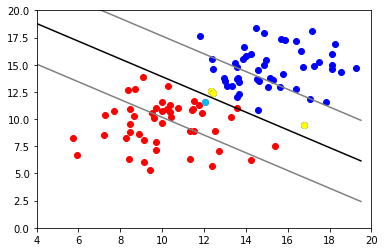

In [38]:
## Caso linealmente no separable penalización baja ##
random.seed(1006)

mal_clasificados = 0
no_linealmente_separable, errores = pegasos(X_no_linealmente_separable,T_no_linealmente_separable,lam=0.009)

for x,t in zip(X_no_linealmente_separable,T_no_linealmente_separable):
  if np.dot(no_linealmente_separable,np.transpose(x)) >= 0:
    plt.scatter(x[1],x[2],c="blue")
    if t < 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="yellow")
  elif np.dot(no_linealmente_separable,np.transpose(x)) < 0:
    plt.scatter(x[1],x[2],c="red")
    if t > 0:
      mal_clasificados +=1
      plt.scatter(x[1],x[2],c="deepskyblue")

x = np.arange(0.0, 20.0, 0.5)
plt.xlim([4,20])
plt.ylim([0,20])
plt.plot(x, separador(x,no_linealmente_separable,0),c="black")
plt.plot(x, separador(x,no_linealmente_separable,1),c="grey")
plt.plot(x, separador(x,no_linealmente_separable,-1),c="grey")

print(no_linealmente_separable)
print("Mal clasificados:",mal_clasificados)

# Algoritmo Pegasus (Con Kernel)

Video mostrando como funciona el RBF Kernel: https://www.youtube.com/watch?v=xWK6G-ub1dY

**Wikipedia dice:**

"The value w is also in the transformed space, with ${\displaystyle \textstyle {\vec {w}}=\sum _{i}\alpha _{i}y_{i}\varphi ({\vec {x}}_{i})}{\displaystyle \textstyle {\vec {w}}=\sum _{i}\alpha _{i}y_{i}\varphi ({\vec {x}}_{i})}$. Dot products with w for classification can again be computed by the kernel trick, i.e. ${\displaystyle \textstyle {\vec {w}}\cdot \varphi ({\vec {x}})=\sum _{i}\alpha _{i}y_{i}k({\vec {x}}_{i},{\vec {x}})}{\displaystyle \textstyle {\vec {w}}\cdot \varphi ({\vec {x}})=\sum _{i}\alpha _{i}y_{i}k({\vec {x}}_{i},{\vec {x}})}$."

*Usamos esto último para clasificar.*

**Aclaración:**

Descartamos el uso de bias para esta parte del análisis, ya que no vimos en el paper que se hablara de la combinación de bias-kernel y sus efectos en el modelo (Y además funciona sin bias).

**Conclusiones:**

- Un $\gamma$ grande hace que la decisión se centre más en puntos particulares, generando una suerte de isla. Si el $\gamma$ es chico la zona que se "levanta" gracias al kernel es grande, y por eso abarca más de lo que debería.

 Es importante encontrar un balance y analizar las opciones para cada caso particular, ya que si bien en este caso un gamma "medio" es la mejor opción, en otros casos puede no serlo (Por ejemplo, en el caso de clases muy pegadas, subir un poco gamma puede ser una buena idea). Si bien puede generar en muchos casos, overfitting.

- Dependiendo de la distribución de los puntos, el modelo puede ser más o menos sencible al $\gamma$ elegido. Sería interesante ver dibujadas las regiones de separación para poder saber mejor qué es lo que varía poco, si lo son las fronteras o simplemente siempre clasifica bien.

In [42]:
def rbf_kernel(X1, X2, gamma):
  resultado = -gamma*((np.linalg.norm(X1-X2))**2)
  resultado = math.exp(resultado)
  return resultado

def kernelized_pegasos(X, T, gamma, lam=0.0009, cantIter=10000):
  alfa = np.zeros(len(X))
  for iter in range(cantIter):
    i = random.randint(0, len(X) - 1)
    decision = 0
    for j in range(len(X)):
      if j != i:
        decision += alfa[j] * T[i] * rbf_kernel(np.array(X[i]), np.array(X[j]), gamma)
    decision *= T[i] / (lam * (iter + 1))
    if decision < 1:
      alfa[i] += 1
  return alfa

def kernelized_clasification(alfa, X, T, dato, gamma):
  resultado = 0
  for x, t, alf in zip(X, T, alfa):
    resultado += alf * t * rbf_kernel(np.array(x), np.array(dato), gamma)
  return resultado

## Análisis clases circulares encerradas

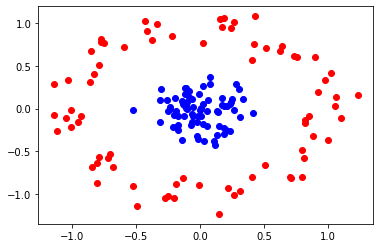

In [43]:
# Genero los datos
np.random.seed(1000)

from sklearn.datasets.samples_generator import make_circles
X_elipse, y = make_circles(150, factor=.2, noise=.12)

T_elipse = [] # Datos asignados a una clase (codificación 1-k)
i = 0
for x_dato,y_dato in zip(X_elipse,y):
  if y_dato == 0:
    T_elipse.append(-1)
  else:
    T_elipse.append(1)

for x,t in zip(X_elipse,T_elipse):
  if t == 1:
    plt.scatter(x[0],x[1],c="blue")
  if t == -1:
    plt.scatter(x[0],x[1],c="red")

X_elipse_train, X_elipse_test, T_elipse_train, T_elipse_test = train_test_split(X_elipse, T_elipse, test_size=0.3, random_state=42)

Mal clasificados: 0


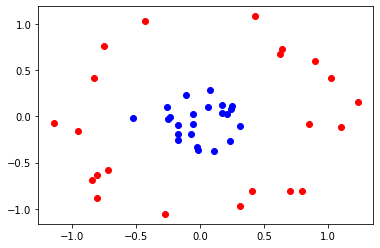

In [46]:
# Caso gamma mediano
random.seed(1000)

mal_clasificados = 0

gamma = 10
alfa_encerradas = kernelized_pegasos(X_elipse_train,T_elipse_train,gamma)

for x,t in zip(X_elipse_test,T_elipse_test):
  if kernelized_clasification(alfa_encerradas,X_elipse_train,T_elipse_train,x,gamma) < 0:
    if t > 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="yellow")
    else:
      plt.scatter(x[0],x[1],c ="red")
  else:
    if t < 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="lightskyblue")
    else:
      plt.scatter(x[0],x[1],c ="blue")

print("Mal clasificados:", mal_clasificados)

Mal clasificados: 22


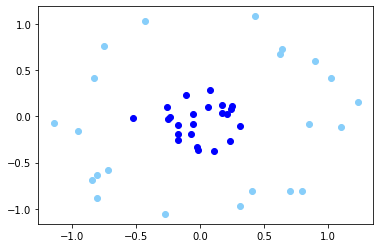

In [52]:
# Caso gamma chico
random.seed(1004)

mal_clasificados = 0

gamma = 1
alfa_encerradas = kernelized_pegasos(X_elipse_train,T_elipse_train,gamma)

for x,t in zip(X_elipse_test,T_elipse_test):
  if kernelized_clasification(alfa_encerradas,X_elipse_train,T_elipse_train,x,gamma) < 0:
    if t > 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="yellow")
    else:
      plt.scatter(x[0],x[1],c ="red")
  else:
    if t < 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="lightskyblue")
    else:
      plt.scatter(x[0],x[1],c ="blue")

print("Mal clasificados:", mal_clasificados)

Mal clasificados: 13


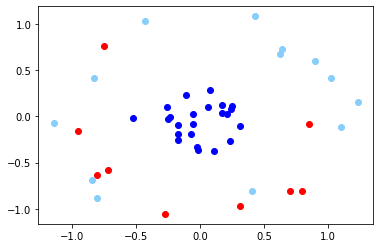

In [55]:
# Caso gamma grande (aparentemente, debe ser MUY grande)
random.seed(1000)

mal_clasificados = 0

gamma = 100000
alfa_encerradas = kernelized_pegasos(X_elipse_train,T_elipse_train,gamma)

for x,t in zip(X_elipse_test,T_elipse_test):
  if kernelized_clasification(alfa_encerradas,X_elipse_train,T_elipse_train,x,gamma) < 0:
    if t > 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="yellow")
    else:
      plt.scatter(x[0],x[1],c ="red")
  else:
    if t < 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="lightskyblue")
    else:
      plt.scatter(x[0],x[1],c ="blue")

print("Mal clasificados:", mal_clasificados)

## Análisis clases linealmente no separable

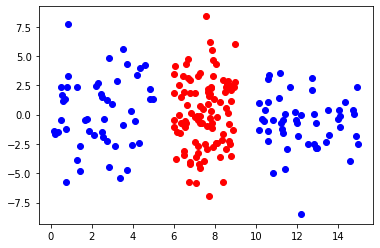

In [56]:
#Genero los datos

X_no_separable = []
T_no_separable = []

for n in range(50):
  X_no_separable.append([np.random.uniform(0,5),np.random.normal(0,3)])
  T_no_separable.append(1)

for n in range(100):
  X_no_separable.append([np.random.uniform(6,9),np.random.normal(0,3)])
  T_no_separable.append(-1) 

for n in range(50):
  X_no_separable.append([np.random.uniform(10,15),np.random.normal(0,3)])
  T_no_separable.append(1)

for x,t in zip(X_no_separable,T_no_separable):
  if t == 1:
    plt.scatter(x[0],x[1],c = "blue")
  if t == -1:
    plt.scatter(x[0],x[1],c = "red")

X_no_separable_train, X_no_separable_test, T_no_separable_train, T_no_separable_test = train_test_split(X_no_separable, T_no_separable, test_size=0.3, random_state=42)

Mal clasificados: 0


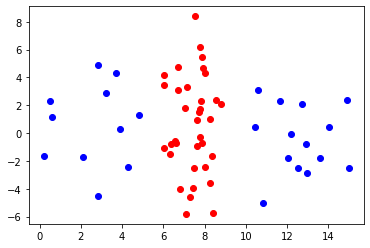

In [57]:
# Caso gamma mediano
random.seed(1000)

mal_clasificados = 0

gamma = 10
alfa_no_separable = kernelized_pegasos(X_no_separable_train,T_no_separable_train,gamma)

for x,t in zip(X_no_separable_test,T_no_separable_test):
  if kernelized_clasification(alfa_no_separable,X_no_separable_train,T_no_separable_train,x,gamma) < 0:
    if t > 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="yellow")
    else:
      plt.scatter(x[0],x[1],c ="red")
  else:
    if t < 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="lightskyblue")
    else:
      plt.scatter(x[0],x[1],c ="blue")

print("Mal clasificados:", mal_clasificados)

Mal clasificados: 6


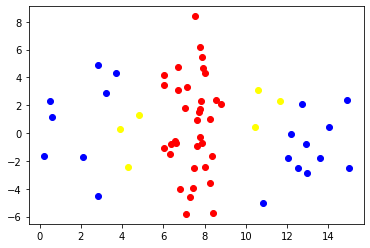

In [60]:
# Caso gamma chico
random.seed(1000)

mal_clasificados = 0

gamma = 0.09
alfa_no_separable = kernelized_pegasos(X_no_separable_train,T_no_separable_train,gamma)

for x,t in zip(X_no_separable_test,T_no_separable_test):
  if kernelized_clasification(alfa_no_separable,X_no_separable_train,T_no_separable_train,x,gamma) < 0:
    if t > 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="yellow")
    else:
      plt.scatter(x[0],x[1],c ="red")
  else:
    if t < 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="lightskyblue")
    else:
      plt.scatter(x[0],x[1],c ="blue")

print("Mal clasificados:", mal_clasificados)

Mal clasificados: 26


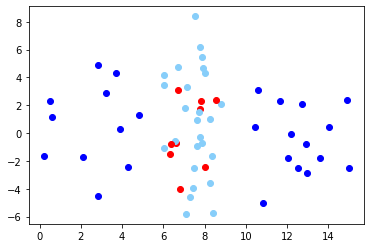

In [62]:
# Caso gamma grande
random.seed(1000)

mal_clasificados = 0

gamma = 10000
alfa_no_separable = kernelized_pegasos(X_no_separable_train,T_no_separable_train,gamma)

for x,t in zip(X_no_separable_test,T_no_separable_test):
  if kernelized_clasification(alfa_no_separable,X_no_separable_train,T_no_separable_train,x,gamma) < 0:
    if t > 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="yellow")
    else:
      plt.scatter(x[0],x[1],c ="red")
  else:
    if t < 0:
      mal_clasificados += 1
      plt.scatter(x[0],x[1],c ="lightskyblue")
    else:
      plt.scatter(x[0],x[1],c ="blue")

print("Mal clasificados:", mal_clasificados)

## Análisis clases solapadas

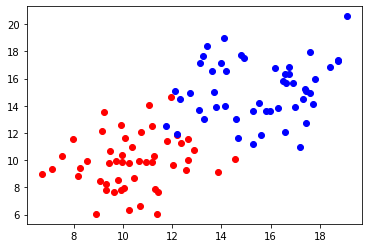

In [73]:
# X_no_linealmente_separable,T_no_linealmente_separable = generador_dos_clases(50, 2, [[10,10],[15,15]])

for x,t in zip(X_no_linealmente_separable,T_no_linealmente_separable):
  if t == 1:
    plt.scatter(x[1],x[2],c ="blue")
  if t == -1:
    plt.scatter(x[1],x[2],c ="red")

X_solapadas_train, X_solapadas_test, T_solapadas_train, T_solapadas_test = train_test_split(X_no_linealmente_separable, T_no_linealmente_separable, test_size=0.5, random_state=42)

Mal clasificados: 2


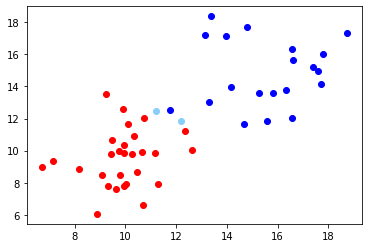

In [74]:
# Caso gamma mediano
random.seed(1000)

mal_clasificados = 0

gamma = 10
alfa_solapadas = kernelized_pegasos(X_solapadas_train,T_solapadas_train,gamma)

for x,t in zip(X_solapadas_test,T_solapadas_test):
  if kernelized_clasification(alfa_solapadas,X_solapadas_train,T_solapadas_train,x,gamma) < 0:
    if t > 0:
      mal_clasificados += 1
      plt.scatter(x[1],x[2],c ="yellow")
    else:
      plt.scatter(x[1],x[2],c ="red")
  else:
    if t < 0:
      mal_clasificados += 1
      plt.scatter(x[1],x[2],c ="lightskyblue")
    else:
      plt.scatter(x[1],x[2],c ="blue")

print("Mal clasificados:", mal_clasificados)

# Cross-Validation

**Concluciones:**

No se puede concluir mucho a partir de esto, sino que más bien confirma lo que veniamos mostrando anteriormente. Tanto para valores extremos de $\lambda$ ($\frac{1}{\lambda n} = C$) y $\gamma$ el modelo no lograr ser general. El encontrar un balance entre los dos hace que el modelo mejore su performance notoriamente.

Resulta interesante ver que inclusive para $\gamma$ distintos, se obtienen resultados similares (o suficientemente buenos).

Lo que indicaría que no hace falta forzar el overfitting para obtener buenos resultados. E inclusive aprovechando esta etapa de cross validation, se pueden evitar usar $\gamma$ muy alto.

In [75]:
def sub(X,d,h):
  i = 0
  X_new = []
  for x in X:
    if i<d or i>=h:
      X_new.append(x)
    i += 1
  return X_new

def crossValidation(X, T, gammas, lambdas): # Gammas = array de gammas, lambdas = array de lambdas
  divisor = len(gammas)*len(lambdas)
  cv_size = int(len(X)/divisor)
  resultado = []
  d = 0
  h = cv_size
  for gam in gammas:
    for lamb in lambdas:
      X_train_CV = sub(X,d,h)
      T_train_CV = sub(T,d,h)
      X_test_CV = X[d:h]
      T_test_CV = T[d:h]

      mal_clasificados = 0
      alfa_cv = kernelized_pegasos(X_train_CV, T_train_CV, gam, lam=lamb)
      for x,t in zip(X_test_CV,T_test_CV):
        if kernelized_clasification(alfa_cv,X_train_CV,T_test_CV,x,gam) < 0:
          if t > 0:
            mal_clasificados += 1
        else:
          if t < 0:
            mal_clasificados += 1
            
      resultado.append({"mc": mal_clasificados, "g": gam, "l": lamb})
      d += cv_size
      h += cv_size

  return sorted(resultado, key=lambda d: d["mc"])

## Caso circular

In [76]:
# Caso circular
random.seed(1000)

circular = crossValidation(X_elipse,T_elipse,[0.01,1,10,1000,10000],[0.0001,0.001,0.00001,0.0005])
print(circular[0])

{'mc': 0, 'g': 1, 'l': 1e-05}


In [77]:
c = defaultdict(dict)
for d in circular:
  c[d["g"]][d["l"]] = d["mc"]

eje x = $\lambda$

eje y = $\gamma$

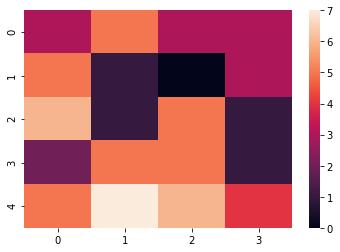

In [79]:
fig = sns.heatmap([[c[g][l] for l in [0.0001,0.001,0.00001,0.0005]] for g in [0.01,1,10,1000,10000]])

## Caso no separable

In [80]:
# Caso no separable

no_separable = crossValidation(X_no_separable,T_no_separable,[0.01,1,10,1000,10000],[0.0001,0.001,0.00001,0.0005])
print(no_separable)

[{'mc': 0, 'g': 0.01, 'l': 0.0001}, {'mc': 0, 'g': 0.01, 'l': 0.001}, {'mc': 0, 'g': 0.01, 'l': 1e-05}, {'mc': 0, 'g': 0.01, 'l': 0.0005}, {'mc': 0, 'g': 1, 'l': 0.0001}, {'mc': 0, 'g': 1, 'l': 0.001}, {'mc': 0, 'g': 1, 'l': 1e-05}, {'mc': 0, 'g': 1, 'l': 0.0005}, {'mc': 0, 'g': 10, 'l': 0.0001}, {'mc': 0, 'g': 10, 'l': 0.001}, {'mc': 0, 'g': 10, 'l': 1e-05}, {'mc': 0, 'g': 10, 'l': 0.0005}, {'mc': 0, 'g': 1000, 'l': 0.0005}, {'mc': 0, 'g': 10000, 'l': 0.0001}, {'mc': 0, 'g': 10000, 'l': 0.001}, {'mc': 0, 'g': 10000, 'l': 1e-05}, {'mc': 0, 'g': 10000, 'l': 0.0005}, {'mc': 10, 'g': 1000, 'l': 0.0001}, {'mc': 10, 'g': 1000, 'l': 0.001}, {'mc': 10, 'g': 1000, 'l': 1e-05}]


eje x = $\lambda$

eje y = $\gamma$

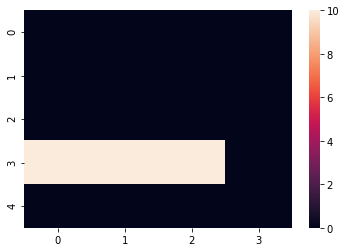

In [84]:
c = defaultdict(dict)
for d in no_separable:
  c[d["g"]][d["l"]] = d["mc"]
fig = sns.heatmap([[c[g][l] for l in [0.0001,0.001,0.00001,0.0005]] for g in [0.01,1,10,1000,10000]])